In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 

In [6]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

(tensor(0.0002), tensor(0.9991))

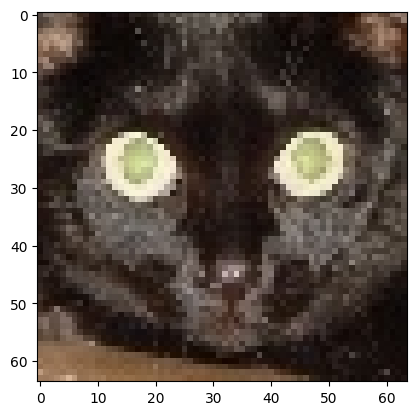

In [30]:
ds=datasets.ImageFolder("./cats1")
i1 = np.array(ds[0][0])

plt.imshow(i1)

sch = DDPM_Scheduler()
sch.forward(5)